[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/Perceptron_and_LinearSVM.ipynb)

# Perceptron 
The Perceptron algorithm finds the linear decision boundary by considering each example $x^{(n)}, y^{(n)} \in \mathcal{D}$, where $y^{(n)} \in \{-1,+1\}$. 
If $\hat{y}^{(n)} = w^\top x^{(n)}$ has a different sign from $y^{(n)}$ the weights are updated to *increase* $\hat{y}^{(n)} {y}^{(n)}$. The gradient of 
$\hat{y}^{(n)} {y}^{(n)}$ wrt. $w$ is $\frac{\partial}{\partial w} y^{(n)}(w^\top x^{(n)}) = y^{(n)} x^{(n)}$. Therefore, if the example is misclassified
the Perceptron learning algorithm simply updates $w$ using
$$
w^{\{t+1\}} \leftarrow w^{\{t\}} + y^{(n)} x^{(n)}
$$
If the data is linearly separable, the algorithm is guaranteed to converge. 
However, if the data is not linearly separable, this procedure does not converge, and oscillates. Below, we use a `max_iters` to in case the data is not linearly seperable. We also record the update *history* so that we can visualize the learning. To be consistent with previous classification methods, we assume the input labels are in $\{0,1\}$.

In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [2]:
class Perceptron:
    
    def __init__(self, add_bias=True, max_iters=10000, record_updates=False):
        """
        Initialize Perceptron binary classifier.
        
        The Perceptron algorithm finds a linear decision boundary by iteratively
        updating weights when examples are misclassified.
        
        Parameters:
        add_bias: if True, adds an intercept term (bias) to the model
        max_iters: maximum number of weight updates (prevents infinite loops)
        record_updates: if True, stores weight history for visualization
        """
        self.max_iters = max_iters
        self.add_bias = add_bias
        self.record_updates = record_updates
        if record_updates:
            self.w_hist = []  # records the weight vector at each update
            self.n_hist = []  # records which data-point triggered each update
    
    def fit(self, x, y):
        """
        Fit the Perceptron model using the Perceptron learning algorithm.
        
        Algorithm: For each misclassified example, update w <- w + y*x
        Guaranteed to converge if data is linearly separable.
        
        Parameters:
        x: input features, shape (N,) or (N, D) where N=samples, D=features
        y: binary labels (0 or 1), shape (N,)
        
        Returns:
        self: fitted model
        """
        # If x is 1D (shape: (N,)), convert to 2D column vector (shape: (N, 1))
        # x[:, None] adds a new axis, transforming (N,) -> (N, 1)
        if x.ndim == 1:
            x = x[:, None]
        
        if self.add_bias:
            N = x.shape[0]
            # Add bias feature: append a column of ones to x
            # np.column_stack horizontally stacks arrays
            # Result: if x is (N, D), new x is (N, D+1)
            x = np.column_stack([x, np.ones(N)])
        
        N, D = x.shape  # N = number of samples, D = number of features (including bias if added)
        
        # Initialize weights to zero, shape (D,)
        w = np.zeros(D)
        
        if self.record_updates:
            w_hist = [w] 
        
        # Convert labels from {0,1} to {-1,+1} for Perceptron math
        # y=0 becomes -1, y=1 becomes +1
        # This allows us to check sign agreement: y*yh > 0 means correct classification
        y = 2*y - 1
        
        t = 0  # iteration counter
        change = True  # if the weight does not change, the algorithm has converged
        
        while change and t < self.max_iters:
            change = False
            
            # Iterate through training examples in random order
            # np.random.permutation(N) creates a random ordering of [0, 1, ..., N-1]
            # This helps avoid cycles in non-separable data
            for n in np.random.permutation(N):
                # Predict the output for this training sample
                # np.dot(x[n,:], w) computes the dot product (scalar)
                # x[n,:] is row n (all columns), shape (D,)
                # w is shape (D,), result is a scalar
                # np.sign converts to -1 or +1
                yh = np.sign(np.dot(x[n, :], w))
                
                # Skip correctly classified samples
                # If yh and y[n] have the same sign, classification is correct
                if yh == y[n]: 
                    continue
                
                # Update rule: w <- w + y*x (gradient ascent on y*w^T*x)
                # When misclassified: y[n]*yh < 0, so we add y[n]*x[n,:] to w
                # This moves the decision boundary toward correct classification
                w = w + y[n] * x[n, :]
                
                if self.record_updates:
                    self.w_hist.append(w)
                    self.n_hist.append(n)
                
                change = True  # weight was updated, continue iterating
                t += 1
                
                if t >= self.max_iters:
                    break
        
        if change:
            print(f'did not converge after {t} updates')
        else:
            print(f'converged after {t} iterations!')
        
        self.w = w
        return self
    
    def predict(self, x):
        """
        Predict binary labels for input x using learned weights.
        
        Parameters:
        x: input features, shape (N,) or (N, D)
        
        Returns:
        yh: predicted labels (0 or 1), shape (N,)
        """
        # Convert 1D to 2D if needed
        if x.ndim == 1:
            x = x[:, None]
        
        Nt = x.shape[0]
        
        if self.add_bias:
            # Add bias feature column to match training format
            x = np.column_stack([x, np.ones(Nt)])
        
        # Compute predictions: sign(w^T @ x)
        # np.dot(self.w, x) with w shape (D,) and x shape (Nt, D) won't work
        # Need to transpose: x.T is (D, Nt), self.w is (D,), result is (Nt,)
        # Or use x @ self.w: (Nt, D) @ (D,) = (Nt,)
        yh = np.sign(np.dot(x, self.w))
        
        # Convert from {-1, +1} back to {0, 1}
        # yh=-1 -> (yh+1)//2 = 0//2 = 0
        # yh=+1 -> (yh+1)//2 = 2//2 = 1
        return (yh + 1) // 2

Let's apply this to do binary classification with Iris flowers dataset. 
Here, we choose the labels and two features to make the task linearly separable.

In [3]:
from sklearn import datasets

# Load the famous Iris dataset
dataset = datasets.load_iris()

# dataset['data'] has shape (150, 4) with 4 features per flower
# Slicing with [:,2:] means: all rows, columns from index 2 onward
# This extracts the last two features (petal length and petal width)
x, y = dataset['data'][:, 2:], dataset['target']

# Keep only classes 0 and 1 (setosa and versicolor), remove class 2 (virginica)
# First condition: y < 2 creates boolean array [True, True, ..., False]
# x[y < 2, :] selects rows where y < 2 (all columns)
# y[y < 2] selects labels where y < 2
# This makes it a binary classification problem
x, y = x[y < 2, :], y[y < 2]

# Fit Perceptron model and record weight updates for visualization
model = Perceptron(record_updates=True)
yh = model.fit(x, y)

converged after 17 iterations!


Let's plot the decision bounday $w^\top x = 0$ using the update history.

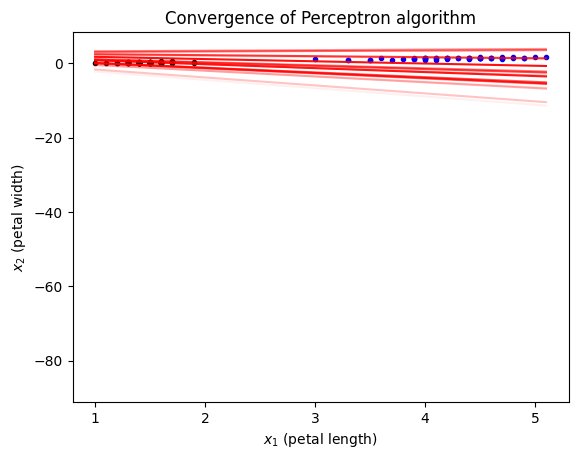

In [4]:
# Plot the two classes with different colors
# x[y==0, 0] selects: rows where y==0, column 0 (first feature)
# x[y==0, 1] selects: rows where y==0, column 1 (second feature)
plt.plot(x[y == 0, 0], x[y == 0, 1], 'k.')  # class 0 in black
plt.plot(x[y == 1, 0], x[y == 1, 1], 'b.')  # class 1 in blue

# Create x values for plotting decision boundary lines
x_line = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100)

# Plot the evolution of decision boundaries
# Decision boundary: w[0]*x1 + w[1]*x2 + w[2] = 0
# Solving for x2: x2 = -(w[0]/w[1])*x1 - w[2]/w[1]
for t, w in enumerate(model.w_hist):
    # Compute slope of decision boundary
    # w[0] is weight for first feature, w[1] for second feature
    # Slope = -w[0]/w[1] (negative because we're solving for x2)
    coef = -w[0] / w[1]
    
    # Plot decision boundary line
    # y-intercept = -w[2]/w[1] where w[2] is the bias term
    # alpha increases over time to show progression (early updates faint, later updates darker)
    plt.plot(x_line, coef * x_line - w[2] / w[1], 'r-', 
             alpha=t / len(model.w_hist), label=f't={t}')

plt.xlabel(r'$x_1$ (petal length)')
plt.ylabel(r'$x_2$ (petal width)')
plt.title('Convergence of Perceptron algorithm')
plt.show()

In [5]:
# Load full Iris dataset to inspect its shape
dataset = datasets.load_iris()

# Extract all 4 features (no slicing on columns)
# dataset['data'][:,:] has shape (150, 4)
# 150 samples, 4 features: sepal length, sepal width, petal length, petal width
x, y = dataset['data'][:, :], dataset['target']

# Print shape to confirm dimensions
print(x.shape)

(150, 4)


Next let's try an example where the data is not linearly separable.

did not converge after 10000 updates


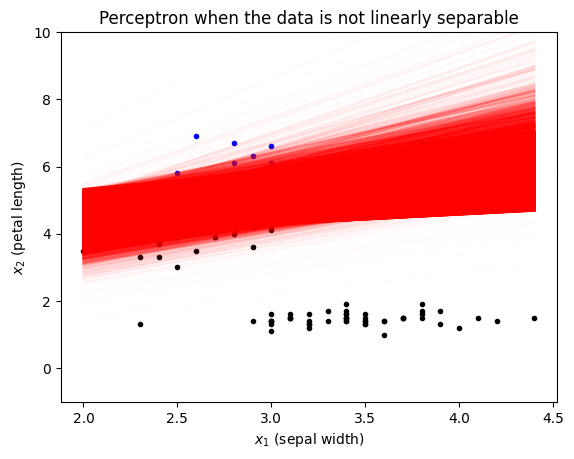

In [6]:
dataset = datasets.load_iris()

# Select features 1 and 2 (sepal width and petal length)
# x[:,[1,2]] is advanced indexing: all rows, columns 1 and 2 only
# This is different from x[:,1:3] slicing - here we explicitly list column indices
x, y = dataset['data'][:, [1, 2]], dataset['target']

# Create binary labels: classes 0,1 vs class 2
# y > 1 creates boolean array: False for classes 0,1, True for class 2
# This converts to {False, True} which Python treats as {0, 1}
y = y > 1

# Fit Perceptron (will hit max_iters because data is not linearly separable)
model = Perceptron(record_updates=True)
yh = model.fit(x, y)

# Plot the two classes
plt.plot(x[y == 0, 0], x[y == 0, 1], 'k.')  # classes 0 and 1 combined
plt.plot(x[y == 1, 0], x[y == 1, 1], 'b.')  # class 2

# Create x values for plotting decision boundaries
x_line = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100)

# Plot all attempted decision boundaries
# Since data is not separable, Perceptron will keep updating without converging
# We see many different decision boundaries tried (up to max_iters)
for t, w in enumerate(model.w_hist):
    # Slope of decision boundary: -w[0]/w[1]
    coef = -w[0] / w[1]
    
    # Plot decision boundary with increasing opacity
    # Early attempts are nearly transparent, later ones more visible
    plt.plot(x_line, coef * x_line - w[2] / w[1], 'r-', 
             alpha=t / len(model.w_hist), label=f't={t}')

plt.xlabel(r'$x_1$ (sepal width)')
plt.ylabel(r'$x_2$ (petal length)')
plt.ylim(-1, 10)
plt.title('Perceptron when the data is not linearly separable')
plt.show()

# Linear Support Vector Machine

As we saw in lectures, soft margin SVM uses **hinge loss** $L(y, z) = \max(0, 1-yz)$. This is in contrast to the Perceptron's loss function $L(y,z) = \max(0, -yz)$. In addition, while Perceptron uses SGD with a learning rate of $\alpha=1$, we can choose other procedures.

In [7]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8, record_history=False):
        """
        Generic gradient descent optimizer.
        
        This class implements the gradient descent algorithm that can be used
        with any differentiable cost function.
        
        Parameters:
        learning_rate: step size for each update (also called alpha)
        max_iters: maximum number of iterations
        epsilon: convergence threshold - stop when ||gradient|| < epsilon
        record_history: if True, stores weight history for visualization
        """
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []
            
    def run(self, gradient_fn, x, y, w):
        """
        Run gradient descent to minimize a cost function.
        
        Parameters:
        gradient_fn: function that computes gradient given (x, y, w)
        x: input features, shape (N, D)
        y: labels, shape (N,)
        w: initial weights, shape (D,)
        
        Returns:
        w: optimized weights after convergence or max_iters, shape (D,)
        """
        # Initialize gradient norm to infinity to ensure loop starts
        grad = np.inf
        
        t = 1  # iteration counter
        
        # Continue until gradient is small (converged) or max iterations reached
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            # Compute gradient at current weights
            # gradient_fn returns shape (D,)
            grad = gradient_fn(x, y, w)
            
            # Update weights: move in opposite direction of gradient
            # w_new = w_old - learning_rate * gradient
            # This is steepest descent
            w = w - self.learning_rate * grad
            
            if self.record_history:
                # Store current weights for visualization
                self.w_history.append(w)
            
            t += 1
        
        return w

Below is a simple implementation of Linear SVM, where the only difference with our previous implementation of logistic regression is the choice of loss function and the fact that the input labels are in $\{-1,+1\}$ rather than $\{0,1\}$ (note that in the implementation below, to keep things simple, we are applying the L2 regularization to the intercept as well.)

In [8]:
def cost_fn(x, y, w, lambdaa):
    """
    Compute the soft-margin SVM cost (hinge loss + L2 regularization).
    
    Cost = mean(max(0, 1 - y*z)) + (lambda/2)*||w||^2
    where z = x @ w are the raw predictions (margin values)
    
    Parameters:
    x: input features, shape (N, D)
    y: labels in {-1, +1}, shape (N,)
    w: weights, shape (D,)
    lambdaa: regularization parameter (controls weight penalty)
    
    Returns:
    J: scalar cost value
    """
    N, D = x.shape  # N = samples, D = features
    
    # Compute margin values: z = x @ w, shape (N,)
    # z represents distance from decision boundary (positive = class +1 side)
    z = np.dot(x, w)
    
    # Hinge loss: max(0, 1 - y*z)
    # For correct classification with margin > 1: loss = 0
    # For margin < 1 or wrong side: loss increases linearly
    # np.maximum computes element-wise max, resulting in shape (N,)
    # np.mean averages over all samples
    # L2 regularization: (lambda/2)*||w||^2 penalizes large weights
    J = np.mean(np.maximum(0, 1 - y * z)) + (lambdaa / 2.) * np.linalg.norm(w)**2
    
    return J

class LinearSVM:    
    def __init__(self, add_bias=True, lambdaa=.01):
        """
        Initialize Linear Support Vector Machine classifier.
        
        Uses hinge loss with L2 regularization to find maximum margin
        decision boundary. More robust than Perceptron for non-separable data.
        
        Parameters:
        add_bias: if True, adds an intercept term to the model
        lambdaa: L2 regularization parameter (higher = more regularization)
        """
        self.add_bias = add_bias
        self.lambdaa = lambdaa
        pass
            
    def fit(self, x, y, optimizer):
        """
        Fit the Linear SVM model using gradient descent on hinge loss.
        
        Parameters:
        x: input features, shape (N,) or (N, D)
        y: binary labels (0 or 1), shape (N,)
        optimizer: GradientDescent instance to use for optimization
        
        Returns:
        self: fitted model
        """
        # Convert 1D to 2D if needed
        if x.ndim == 1:
            x = x[:, None]
        
        if self.add_bias:
            N = x.shape[0]
            # Add bias feature column
            x = np.column_stack([x, np.ones(N)])
        
        N, D = x.shape
        
        # Convert labels from {0, 1} to {-1, +1}
        # SVM math requires this encoding for margin calculations
        y = 2*y - 1
        
        def subgradient(x, y, w):
            """
            Compute subgradient of hinge loss + L2 regularization.
            
            Hinge loss is not differentiable at y*z = 1, so we use subgradient.
            
            Parameters:
            x: input features, shape (N, D)
            y: labels in {-1, +1}, shape (N,)
            w: current weights, shape (D,)
            
            Returns:
            grad: subgradient vector, shape (D,)
            """
            N, D = x.shape
            
            # Compute margin values: yh = x @ w, shape (N,)
            yh = np.dot(x, w)
            
            # Find violations: samples where margin < 1
            # yh*y < 1 creates boolean array, shape (N,)
            # np.nonzero returns tuple of arrays; [0] gives the indices
            # violations is a 1D array of indices where hinge loss is active
            violations = np.nonzero(yh * y < 1)[0]
            
            # Compute gradient contribution from hinge loss
            # x[violations, :] selects rows with violations, shape (len(violations), D)
            # y[violations] selects corresponding labels, shape (len(violations),)
            # x.T @ y is matrix-vector product: (D, len(violations)) @ (len(violations),) = (D,)
            # We compute -x^T @ y for violated constraints, then average by N
            grad = -np.dot(x[violations, :].T, y[violations]) / N
            
            # Add gradient from L2 regularization: lambda * w
            grad += self.lambdaa * w
            
            return grad

        # Initialize weights to zero
        w0 = np.zeros(D)
        
        # Run gradient descent to find optimal weights
        self.w = optimizer.run(subgradient, x, y, w0)
        
        return self
    
    def predict(self, x):
        """
        Predict binary labels for input x.
        
        Parameters:
        x: input features, shape (N,) or (N, D)
        
        Returns:
        yh: predicted labels (0 or 1), shape (N,)
        """
        if self.add_bias:
            # Add bias feature column
            # Note: This should use x.shape[0], not N (which is not defined here)
            x = np.column_stack([x, np.ones(x.shape[0])])
        
        # Compute predictions: sign(x @ w)
        # x @ self.w performs matrix-vector multiplication
        # If x is (N, D) and self.w is (D,), result is (N,)
        # np.sign returns -1 or +1
        # Convert from {-1, +1} to {0, 1} using (sign + 1) // 2
        yh = (np.sign(x @ self.w) + 1) // 2
        
        return yh

Let's try again to fit the Iris dataset of previous example this time using linear SVM; this is the setting where the data is not linearly separable.

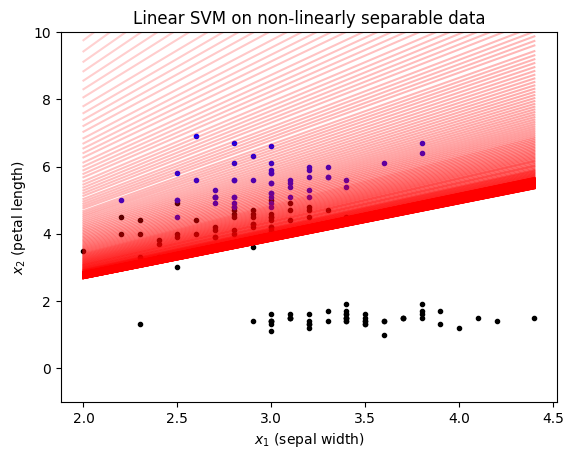

In [9]:
dataset = datasets.load_iris()

# Select features 1 and 2 (same non-separable setup as Perceptron example)
x, y = dataset['data'][:, [1, 2]], dataset['target']

# Create binary classification: classes 0,1 vs class 2
y = y > 1

# Create optimizer with history recording
# learning_rate: smaller than default for stability with SVM
# max_iters: 300 iterations for demonstration
optimizer = GradientDescent(learning_rate=.01, max_iters=300, record_history=True)

# Fit Linear SVM model
# Very small lambda (weak regularization) to focus on margin maximization
model = LinearSVM(lambdaa=.00001)
model.fit(x, y, optimizer)

# Plot the two classes
plt.plot(x[y == 0, 0], x[y == 0, 1], 'k.')  # classes 0 and 1 combined (black)
plt.plot(x[y == 1, 0], x[y == 1, 1], 'b.')  # class 2 (blue)

# Create x values for decision boundary visualization
x_line = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100)

# Plot evolution of decision boundary during optimization
# Unlike Perceptron (which oscillates), SVM converges smoothly to maximum margin
for t, w in enumerate(optimizer.w_history):
    # Decision boundary equation: w[0]*x1 + w[1]*x2 + w[2] = 0
    # Solving for x2: x2 = (-w[0]/w[1])*x1 - w[2]/w[1]
    coef = -w[0] / w[1]
    
    # Plot decision boundary
    # Alpha increases to show convergence (early iterations faint, final solution dark)
    plt.plot(x_line, coef * x_line - w[2] / w[1], 'r-', 
             alpha=t / len(optimizer.w_history), label=f't={t}')

plt.xlabel(r'$x_1$ (sepal width)')
plt.ylabel(r'$x_2$ (petal length)')
plt.ylim(-1, 10)
plt.title('Linear SVM on non-linearly separable data')
plt.show()